In [ ]:
%cd ../../..

In [2]:
import os
import torch
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

import smart_settings

from mbrl import allogger
from mbrl.models import forward_model_from_string
from mbrl.environments import env_from_string
from mbrl import torch_helpers
from mbrl.controllers.abstract_controller import OpenLoopPolicy
from mbrl.rolloutbuffer import RolloutBuffer
from mbrl.rolloutbuffer import SimpleRolloutBuffer 
from mbrl.seeding import Seeding

device = torch.device("cuda:0")
torch_helpers.device = device


In [3]:
Seeding.set_seed(134734)

In [4]:
env_params = {
  "env": "FetchPickAndPlaceConstruction",
  "env_params": {
    "sparse": True,
    "shaped_reward": True,
    "num_blocks": 4,
    "stack_only": True,
    "case": "Singletower",
    "visualize_target": False,
    "visualize_mocap": False
  },
}
env = env_from_string("FetchPickAndPlaceConstruction", **env_params["env_params"])

In [5]:
def load_model(path, checkpoint_suffix, env):
    params = smart_settings.load(os.path.join(path, 'settings.json'), make_immutable=False)
    forward_model = forward_model_from_string(params.forward_model)(
            env=env, **params.forward_model_params
        )
    forward_model.load(os.path.join(path, 'checkpoints' + checkpoint_suffix, 'forward_model'))
    print(f"Loading model from checkpoint {checkpoint_suffix}!")
    return forward_model

In [6]:
model_path = "results/cee_us/construction/gnn_ensemble_cee_us_freeplay"
params = smart_settings.load(os.path.join(model_path,'settings.json'), make_immutable=False)
params['working_dir'] = '/tmp/test'

In [7]:
assert params['working_dir'] == '/tmp/test'
allogger.basic_configure(logdir=params.working_dir, default_outputs=['hdf'],
                         hdf_writer_params=dict(min_time_diff_btw_disc_writes=1))

In [8]:
initial_obs = env.reset()

In [9]:
## RUN THE FOLLOWING ONLY IF YOU DIDN'T UNSET LD_PRELOAD!

# from mujoco_py import GlfwContext
# GlfwContext(offscreen=True)

In [10]:
fig_path = ""
save_fig = False

In [11]:
env.set_state_from_observation(initial_obs)

## Make robot invisible for rendering!

In [12]:
for geom_name in env.sim.model.geom_names:
    if "robot0" in geom_name or "gripper" in geom_name:
        geom_id = env.sim.model.geom_name2id(geom_name)
        env.sim.model.geom_rgba[geom_id, 3] = 0.

In [13]:
def render_rgb_array_with_cam(env, width, height, camera_name):
    env._render_callback()
    data = env.sim.render(width, height, camera_name=camera_name)  # options: fixed (camera from front)
    # original image is upside-down, so flip it
    return data[::-1, :, :]

## Render current state of environment from top camera

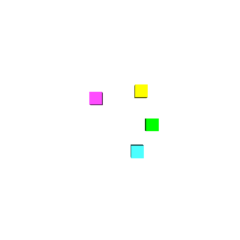

In [14]:
real_env_img = render_rgb_array_with_cam(env, width=1000, height=1000, camera_name='top_cam')
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
ax.imshow(real_env_img)

ax.axis('off')
fig.tight_layout()

if save_fig:
    fig.savefig(os.path.join(fig_path,"environment_top.png"), dpi=600)

### Prepare variable for heatmap generation

In [15]:
robot_base_xy = np.array([0.69189994, 0.74409998])
manipulability_r = 0.8531

gripper_init = np.array([1.344,  0.749,  0.5319])

In [16]:
env.set_state_from_observation(initial_obs)

In [17]:
# Object locations
# initial_obs[10:13], initial_obs[22:25], initial_obs[34:37], initial_obs[46:49]

In [18]:
def evaluate(obs, action, model):
    if obs.ndim == 1 and action.ndim == 1:
        obs = obs[None,...]
        action = action[None,None,...] # assuming horizon is 1
    elif obs.ndim == 1 and action.ndim == 2:
        obs = np.tile(obs, (action.shape[0], 1))
        action = action[:,None,:]
    start_obs = torch.from_numpy(obs).float().to(device)
    action_sequence = torch.from_numpy(action).float().to(device)
    with torch.no_grad():
        policy = OpenLoopPolicy(action_sequence)
        out = model.predict_n_steps(start_observations=start_obs, start_states=None, policy=policy, horizon=1)[0]

    return out

# Get epistemic uncertainty heatmaps GNN

### Specify for which checkpoint!

In [19]:
checkpoint_name = "_299"

### Generate 100 random actions to evaluate disagreement:

In [20]:
random_actions = np.random.uniform(-1.0, 1.0, (100,4))

### Generate the grid for evaluation:

In [21]:
nx, ny = (0.005, 0.005)

x = np.arange(gripper_init[0]-0.4, gripper_init[0]+0.4+nx, nx)

y = np.arange(gripper_init[1]-0.4, gripper_init[1]+0.4+ny, ny)

yv, xv = np.meshgrid(y, x)

### Compute epistemic uncertainty heatmap:

In [22]:
uncertainties = []
ensemble_model = load_model(
    model_path,
    checkpoint_name,
    env
)
for id_m,(y,x) in enumerate(zip(yv.flatten(),xv.flatten())):
    new_obs = initial_obs.copy()
    new_obs[0] = x 
    new_obs[1] = y
    new_obs[2] = 0.42
    out = evaluate(new_obs, random_actions, ensemble_model)

    ensemble_disagreement_all_dims = np.std(out['next_observations'].squeeze(-2).cpu().detach().numpy(), axis=1)
    ensemble_disagreement_for_each_action = np.sum(ensemble_disagreement_all_dims, -1)
    uncertainties.append(np.mean(ensemble_disagreement_for_each_action))

uncertainty_map = np.reshape(np.asarray(uncertainties), xv.shape)
    

Loading model from checkpoint _299!


## Plot heatmap

In [23]:
plt.style.use('experiments/cee_us/hooks/post_rollout_hooks/prettyplots.mplstyle')
colors = [(0.368, 0.507, 0.71), (0.881, 0.611, 0.142), (0.923, 0.386,0.209),
          (0.56, 0.692, 0.195),(0.528, 0.471, 0.701), (0.772, 0.432,0.102),
          (0.572, 0.586, 0.) ]

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FormatStrFormatter

cmap = LinearSegmentedColormap.from_list("", [(1., 1., 1.),colors[1],colors[2]])

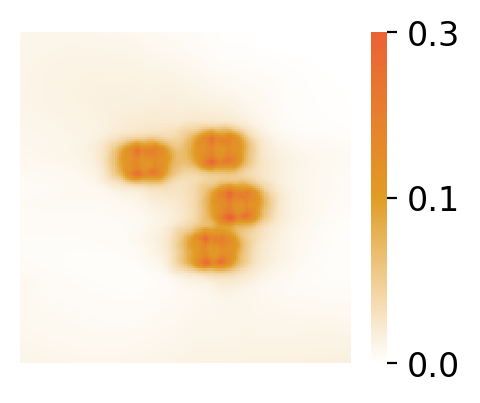

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

min_lim = np.min(uncertainty_map) 
max_lim = np.max(uncertainty_map) 
cbar_ticks = dict(ticks=[min_lim,
                     (min_lim+max_lim)/2,
                     max_lim]) 

sns.heatmap(uncertainty_map,
            ax=ax,
            cbar=True,
            square=True,
            xticklabels=False,
            yticklabels=False,
            linewidths=0.0, rasterized=True,
            vmin=min_lim, vmax=max_lim,
            cmap = cmap,
            cbar_kws = cbar_ticks,
           cbar_ax = cax,)

cax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
fig.tight_layout()

if save_fig:
    fig.savefig(os.path.join(fig_path, f"construction_epistemic_uncertainty_heatmap_cpt{checkpoint_name}.png"), dpi=300)
    # fig.savefig(os.path.join(fig_path, f"construction_epistemic_uncertainty_heatmap_cpt{checkpoint_name}.svg"))


## Following part is to get the pixel positions from world coordinates
For correct visualization, for the world coordinates used for the grid in the uncertainty heatmap generation, we get the bounding box in the pixel coordinates 

In [25]:
from gym.envs.robotics.rotations import quat2mat
import math

def compute_cam_mat(render_width, render_height, camera_name):
    assert camera_name in env.sim.model.camera_names
    camera_id = env.sim.model.camera_name2id(camera_name)

    R_cam2world = quat2mat(env.sim.model.cam_quat[camera_id])
    T_cam2world = env.sim.model.cam_pos[camera_id]

    fovy = env.sim.model.cam_fovy[camera_id]
    fovy = (np.pi / 180) * fovy # convert to radians
    f = 0.5 * render_height / math.tan(fovy / 2)
    K_cam = np.array(((-f, 0, render_width / 2), (0, f, render_height / 2), (0, 0, 1)))       
    return R_cam2world, T_cam2world, K_cam

def get_center_of_mass_in_pixels(entity_positions, render_width, render_height, camera_name="top_cam",
                                 return_ratio=False):
    R_cam2world, T_cam2world, K_cam = compute_cam_mat(render_width, render_height, camera_name)
    # Return entity pos shape (num rollous x) episode_length x num_entities x 3
    entity_positions_cam = np.transpose(R_cam2world) @ (entity_positions - T_cam2world)[...,np.newaxis]
    # entity_positions_cam shape (num rollous x) episode_length x num_entities x 3 x 1 (the last axis for matrix mult.)
    z_for_normalization = entity_positions_cam[...,2,0]
    entity_positions_cam = entity_positions_cam/z_for_normalization[..., np.newaxis, np.newaxis]
    pixel_loc = K_cam @ entity_positions_cam
    pixel_loc = np.round(pixel_loc[...,0])
    if return_ratio:
        return pixel_loc[...,:2]/np.array([render_width,render_height])
    else:
        return pixel_loc[...,:2]


In [26]:
positions = np.array([[xv[0,0],yv[0,0],0.42],[xv[-1,-1],yv[-1,-1],0.42]])
corners = get_center_of_mass_in_pixels(positions,1000,1000)

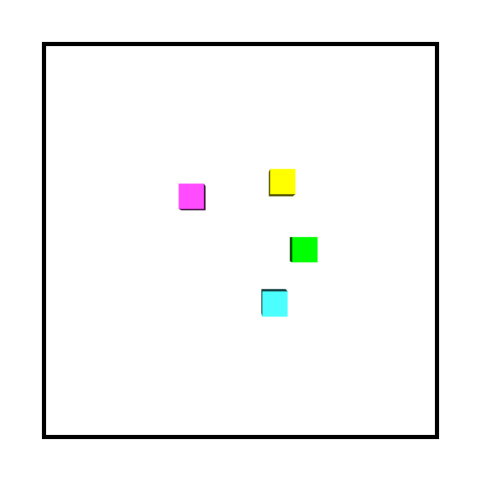

In [27]:
import matplotlib.patches as patches

real_env_img = render_rgb_array_with_cam(env, width=1000, height=1000, camera_name='top_cam')
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
ax.imshow(real_env_img)

box_width = corners[1,0] - corners[0,0]
box_height = corners[1,1] - corners[0,1]
rect = patches.Rectangle((corners[0,0], corners[0,1]),
                         box_width, box_height, linewidth=1.5, edgecolor='black', facecolor='none')
ax.add_patch(rect)
ax.axis('off')
fig.tight_layout()
if save_fig:
    fig.savefig(os.path.join(fig_path,"environment_top_bounded.png"), dpi=600)